# Language Modelling with Transformers

In this notebook we are gonna build a language model with Transformers.

We handle data preparation/batching with Torchtext.
We use mosestokenizer for tokenizing paragraphs.

In [1]:
!pip install torch==1.7.1+cu101 torchvision==0.8.2+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U torchtext
!pip install -U mosestokenizer

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.4MB 25kB/s 
     |████████████████████████████████| 12.8MB 237kB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101
     |████████████████████████████████| 7.0MB 4.8MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1
  Created wheel for mosestokenizer: filename=mosestokenizer-1.1.0-cp36-none-any.whl size=49120 sha256=2670bfe6f568e25a45b36f5e6ee129f0fb527566cc83996b6dbc46679210cd1a
  Stored in directory: /root/.cache/pip/wheels/a2/e7/48/48d5e0f9c0cd5def2dfd7cb8543945f906448ed1313de24a29
  Created wheel for uctools: filename=uctools-1.3.0-cp36-none-any.whl size=6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7-h-dG6q3IZuAu081cjhHmmgnz4ott4BEXPoHkw1M7BE8JN--7xw4


In [ ]:
#import utils
import sys
sys.path.append('/content/drive/MyDrive/demetre_{pipia, uridia}')
import utils

In [ ]:
import math

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torchtext
from torchtext.datasets import LanguageModelingDataset

assert torchtext.__version__ == '0.8.1'
assert torch.__version__.startswith('1.7')

from mosestokenizer import *
import gensim
from tqdm import tqdm_notebook
from gensim.models import KeyedVectors

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# using utils
# Get text field and data loaders for lstm model

w2v_model_path = '/content/drive/MyDrive/demetre_{pipia, uridia}/resources/word2vec.model_paragraph_all_only_georgian_shuffled_3M_30it'
df_path = '/content/drive/MyDrive/demetre_{pipia, uridia}/data/paragraph_all_only_georgian_shuffled.csv'
text_field = utils.TextField(w2v_model_path, df_path, batch_first = False) 
txt_field = text_field.get_txt_field()

train_dl, dev_dl, test_dl = utils.DataLoader(text_field, device).get_dls()

/usr/local/lib/python3.6/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.6/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)
/content/drive/MyDrive/NLP Final Project/utils.py:173: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-w

In [ ]:
batch = next(iter(train_dl))

# output shape should be (batch_size, bptt_len). Note that, if we used batch_first=False in above, we would've got (bptt_len, batch_size) instead.
batch.text.shape, batch.target.shape 

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


(torch.Size([10, 128]), torch.Size([10, 128]))

In [ ]:
# Note that 'target' is left-shifted version of 'text', as we want for next word prediction!
batch.text[:,11], batch.target[:,11]

(tensor([    0,     0,  1614,   495, 27260, 20908,     4,    73,     0, 16530],
        device='cuda:0'),
 tensor([    0,  1614,   495, 27260, 20908,     4,    73,     0, 16530,   677],
        device='cuda:0'))

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)

        # register buffer means that data will be saved/loaded when accessing state_dict. 
        # See more hear https://discuss.pytorch.org/t/what-is-the-difference-between-register-buffer-and-register-parameter-of-nn-module/32723

        self.register_buffer('pe', pe)

    def forward(self, x):

        # embeddings are summed with positional encodings and altogether go through the dropout layer.

        x = x + self.pe[:x.size(0), :]

        return self.dropout(x)

In [ ]:
class TransformerModel(nn.Module):

    def __init__(self, 
                 ntoken, # ლექსიკონის ზომა
                 ninp, # word embedding-ების ზომა
                 nhead, # Number of heads in multi-head attention
                 nhid, # size of the hidden layer (dimension of feed-forward network in transformer block)
                 nlayers, # number of transformer stacked blocks
                 txt_field,
                 dropout=0.5):
      
        super(TransformerModel, self).__init__()

        self.model_type = 'Transformer'

        self.pos_encoder = PositionalEncoding(ninp, dropout)

        encoder_layers = nn.TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, nlayers)

        
        self.encoder = nn.Embedding.from_pretrained(torch.FloatTensor(txt_field.vocab.vectors))
        self.ninp = ninp

        # final linear map back to vocabulary (gives probability distribution over words)
        self.decoder = nn.Linear(ninp, ntoken)

        self.init_weights()

    def generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def init_weights(self):
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        # src_mask is triangular matrix to mask-out future tokens (since we are using uni-directional LM)
        src_mask = model.generate_square_subsequent_mask(src.size(0)).to(device)

        src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output

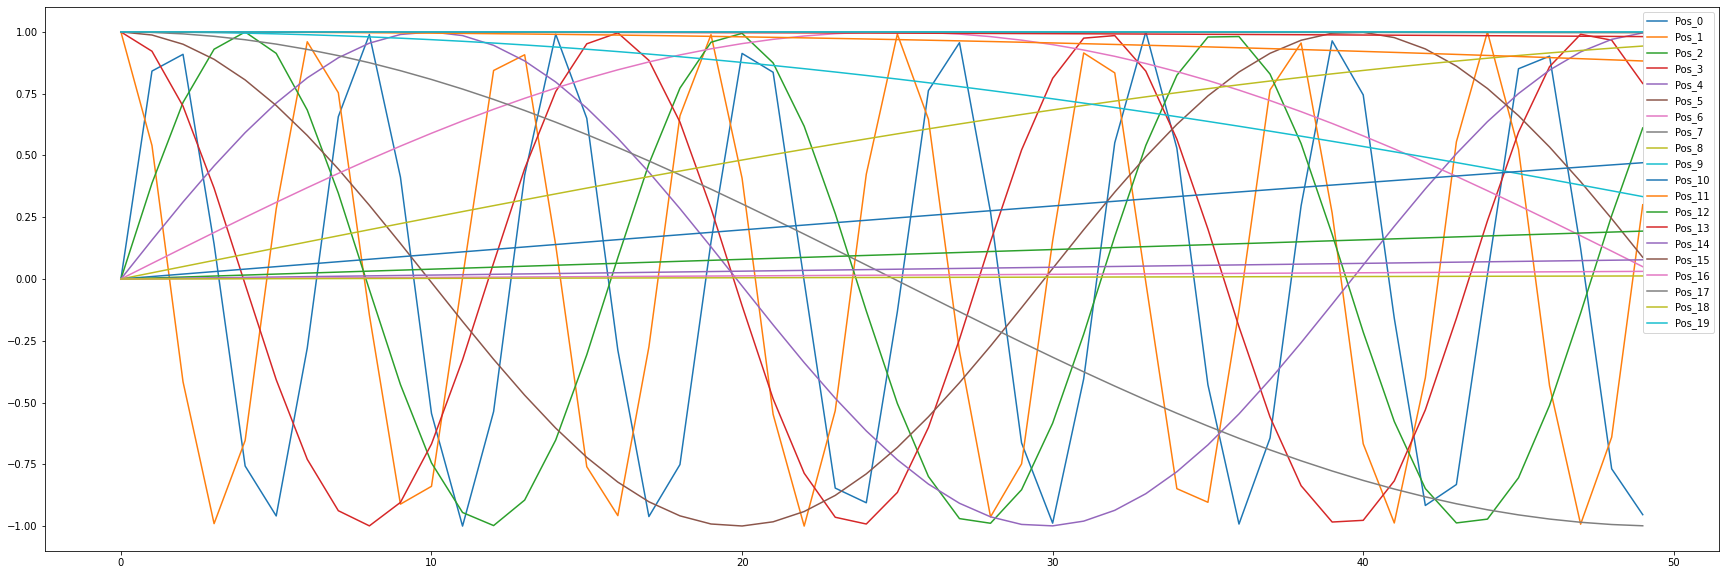

In [ ]:
# პოზიციური კოდირების ვიზუალიზაცია (embedding dim=20, max sequence length=50)

p = PositionalEncoding(20, max_len=50)

pe = p.pe.squeeze(1).numpy()

plt.figure(figsize=(30, 10))
for i in range(20):
  sns.lineplot(np.arange(0, 50), pe[:,i].reshape(-1), label=f'Pos_{i}')
plt.legend()

In [ ]:
EMBED_SIZE = 100

In [ ]:
model = TransformerModel(len(txt_field.vocab), EMBED_SIZE, 4, 200, 4, txt_field, 0.2).to(device)

In [ ]:
epochs = 1
model_save_path = '/content/drive/MyDrive/demetre_{pipia, uridia}/resources/model_transformer_tmp'
utils.train_loop(model, train_dl, dev_dl, device, epochs, model_save_path)

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch 1 | Iter 100 | Avg Train Loss 10.762655906677246 | Dev Perplexity None | LR  0.0001
Epoch 1 | Iter 200 | Avg Train Loss 9.854265022277833 | Dev Perplexity None | LR  0.0001
Epoch 1 | Iter 300 | Avg Train Loss 9.21268102645874 | Dev Perplexity None | LR  0.0001
Epoch 1 | Iter 400 | Avg Train Loss 8.780469799041748 | Dev Perplexity None | LR  0.0001
Epoch 1 | Iter 500 | Avg Train Loss 8.52820071220398 | Dev Perplexity 4207.792975332257 | LR  0.0001
Epoch 1 | Iter 600 | Avg Train Loss 8.398196716308593 | Dev Perplexity 4207.792975332257 | LR  0.0001
Epoch 1 | Iter 700 | Avg Train Loss 8.357113647460938 | Dev Perplexity 4207.792975332257 | LR  0.0001
Epoch 1 | Iter 800 | Avg Train Loss 8.310259199142456 | Dev Perplexity 4207.792975332257 | LR  0.0001
Epoch 1 | Iter 900 | Avg Train Loss 8.3249911403656 | Dev Perplexity 4207.792975332257 | LR  0.0001
Epoch 1 | Iter 1000 | Avg Train Loss 8.307244443893433 | Dev Perplexity 3632.577327746097 | LR  0.0001
Epoch 1 | Iter 1100 | Avg Train Lo

In [ ]:
#load model
model = TransformerModel(len(txt_field.vocab), EMBED_SIZE, 4, 200, 4, txt_field, 0.2).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/demetre_{pipia, uridia}/resources/model_transformer_300K', map_location=device))

<All keys matched successfully>

In [ ]:
def generate_top_p_text(model, context, length:int = 10):

    model = model.to(device)
    model.eval()
    with torch.no_grad(): # tells Pytorch not to store values of intermediate computations for backward pass because we not gonna need gradients.
        
        vocab = txt_field.vocab

        context = context.split(' ')
        for i in range(length):

            x = [vocab.stoi.get(word, vocab.unk_index) for word in context[-context_len:]]
            x = torch.LongTensor(x).view(1, len(context[-context_len:])).to(device)
            
            predictions = torch.nn.Softmax()(model(x)[0,-1,:])
            prediction_indice = 0
            while prediction_indice in [0,1, 2]: # not to get <unk> <pad> and <eos>
                prediction_indice = utils.top_p(predictions, 0.8)
            
            # if prediction_indice == 2: break
            context.append(vocab.itos[ prediction_indice] )

    return ' '.join(context)

generate_top_p_text(model, 'პარლამენტი', 10)

# Compute perplexity on test set

In [ ]:
print(utils.compute_perplexity(model, test_dl, device))

/usr/local/lib/python3.6/dist-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


754.6861970427638
